# Example on the urban canopy data 

In [1]:
from pivpy import io, graphics, pivpy
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import pkg_resources as pkg
%matplotlib inline

In [2]:
# one file 
data = io.load_vc7(pkg.resource_filename('pivpy','data/urban_canopy/B00001.vc7'))

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f1fe37632d0>)

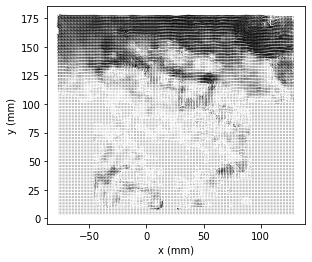

In [3]:
# data.attrs['units'] = ['mm','mm','m/s','m/s']
graphics.quiver(data,arrScale=50)

In [4]:
path = pkg.resource_filename('pivpy','data/urban_canopy')
data = io.load_directory(path,basename='B*',ext='.vc7')
data.attrs['units'] = ['mm','mm','m/s','m/s'] # fix units or fix the code

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f1fae828390>)

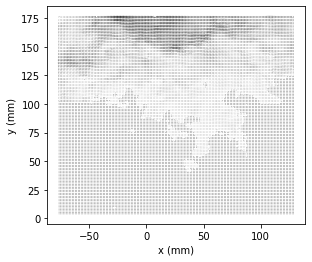

In [5]:
graphics.quiver(data.isel(t=-1),arrScale=100) # show last

In [6]:
# let's try a vertical profile

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f1fa86b2050>)

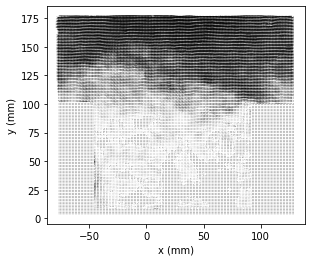

In [7]:
graphics.quiver(data.piv.average,arrScale=50)

Text(0, 0.5, 'z (mm)')

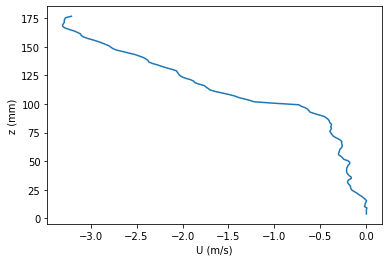

In [8]:
# Let's try vertical profile of streamwise mean velocity U(z)
# we could define it a shortcut of the type:
# graphics.profile(velocity_component = 'u', coordinate = 'z') 
plt.plot(data.mean(dim='x').mean(dim='t').u,data.y)
plt.xlabel('U (m/s)')
plt.ylabel('z (mm)')

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f1fa3b0e9d0>)

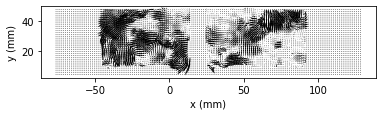

In [9]:
graphics.quiver(data[dict(y=slice(100, 175))])
# something strange with the mask

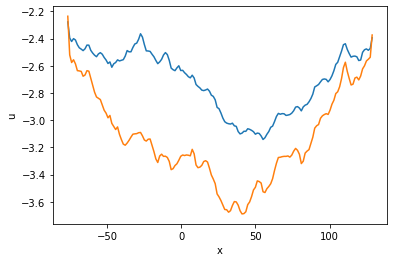

In [10]:
# let's test homogeneity above the canopy: 
# take y above some value and .mean(dim='y')
# take mean with time .mean(dim='t')
# plot:
data.where(data.y>120,drop=True).mean(dim='t').mean(dim='y').u.plot()
data.where(data.y>150,drop=True).mean(dim='t').mean(dim='y').u.plot()

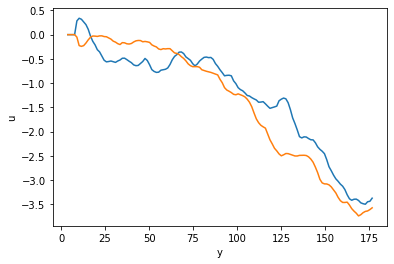

In [11]:
data.where((data.x > -40) & (data.x < 0), drop=True).mean(dim='t').u.mean(dim='x').plot()
data.where((data.x > 20) & (data.x < 80), drop=True).mean(dim='t').u.mean(dim='x').plot()

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f1fa82a44d0>)

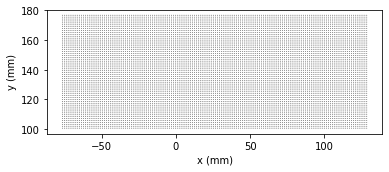

In [12]:
graphics.quiver(data.where(data.y>100,drop=True).mean(dim='t'),units=['mm','mm','m/s','m/s'],arrScale=500)

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f1fa3c87a90>)

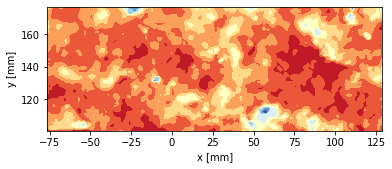

In [13]:
# and some cool plot of average TKE above the canopy 
graphics.contour_plot(data.piv.tke().mean(dim='t').where(data.y > 100,drop=True),units=data.attrs['units'])